In [1]:
!nvidia-smi

Tue Apr 21 10:26:11 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 430.50       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 27%   33C    P8    27W / 250W |      0MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:1B:00.0 Off |                  N/A |
| 27%   41C    P8    30W / 250W |      0MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [6]:
# Necessary imports
%load_ext autoreload
%autoreload 2

import os
import sys
import warnings
import logging
import json

from torch import nn
import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from glob import glob

sys.path.append('..')
from seismiqb import *
from seismiqb.src.controller import *

# Set GPU
%env CUDA_VISIBLE_DEVICES=0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: CUDA_VISIBLE_DEVICES=0


In [7]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from itertools import  filterfalse as ifilterfalse


def a_loss(pred, target):
    return dice_loss(pred, target) + 4*torch.nn.BCEWithLogitsLoss()(pred, target)

In [8]:
%%time
c = Controller(save_dir='./testing/', )

CPU times: user 306 µs, sys: 167 µs, total: 473 µs
Wall time: 382 µs


In [9]:
%%time
train_paths = [
#     '/data/seismic/CUBE_1/E_anon.hdf5',
#     '/data/seismic/CUBE_3/P_cube.hdf5',
#     '/data/seismic/CUBE_4/R_cube.hdf5',
    '/data/seismic/CUBE_2/M_cube.hdf5',
]

train_dataset = c.make_dataset(train_paths)

CPU times: user 3.3 s, sys: 302 ms, total: 3.6 s
Wall time: 3.6 s


In [10]:
%%time
c.make_sampler(train_dataset, each=100, side_view=0.3)

CPU times: user 6.4 s, sys: 246 ms, total: 6.64 s
Wall time: 6.64 s


In [ ]:
%%time
c.train(train_dataset, n_epochs=150, use_grid=False)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
# c.train_pipeline.m('ED').model

In [ ]:
for p in c.train_pipeline.m('ED').model.parameters():
    print(p.grad.shape, p.grad.dim(), tuple(range(0, 3)))
    break

In [ ]:
test_paths = [
    '/data/seismic/CUBE_2/M_cube.hdf5',
#     '/data/seismic/CUBE_5/AMP.hdf5',
#     '/data/seismic/CUBE_10/10_cube.hdf5',
]

In [ ]:
%%time
test_dataset = c.make_dataset(test_paths)

In [ ]:
c.inference(test_dataset, 1, orientation='i', overlap_factor=2, adjacency=15,)

In [ ]:
c.predictions[0].show()

In [ ]:
_ = c.evaluate()

In [ ]:
c.inference(test_dataset, 1, orientation='ix')

In [ ]:
c.evaluate()

In [ ]:
hm = HorizonMetrics((c.predictions[1], test_dataset.labels[0]))
hm.horizon.show()
_ = hm.evaluate('support_hellinger', plot=True, plot_kwargs={'cmap': 'Reds'})
_ = hm.evaluate('compare', plot=True, agg=None, plot_kwargs={'cmap': 'Reds'})

In [ ]:
c.predictions[0].show()

In [ ]:
len(c.predictions[4])

# Enhance

In [ ]:
from seismiqb.batchflow import Pipeline, FilesIndex
from seismiqb.batchflow import B, V, C, F, D, P, R, W, L

In [11]:
c_enhance = EnhanceController(save_dir='./enhance_testing/', crop_shape=(1, 64, 64), batch_size=1, device=0)

in make logger
<bound method Logger.info of <Logger controller_logger (INFO)>>


In [12]:
test_paths = [
    '/data/seismic/CUBE_2/M_cube.hdf5',
]

test_dataset = c_enhance.make_dataset(test_paths)

In [14]:
%%time 
c_enhance.make_sampler(test_dataset, each=100, side_view=0.5, use_grid=False)

CPU times: user 4.3 s, sys: 79.7 ms, total: 4.38 s
Wall time: 4.38 s


In [15]:
c_enhance.enhance_train(test_dataset, n_epochs=10)

1
(1, 64, 64) CROP SHAPE
in_channels 1
in get_enhance_train_template


-0.18323693

In [16]:
c_enhance.enhance_inference(test_dataset, 2, test_dataset.labels[test_dataset.indices[0]][0])

started 0



started 1


<horizon t0_G_anon for M_cube.hdf5 at 0x7f5d38c0e940>

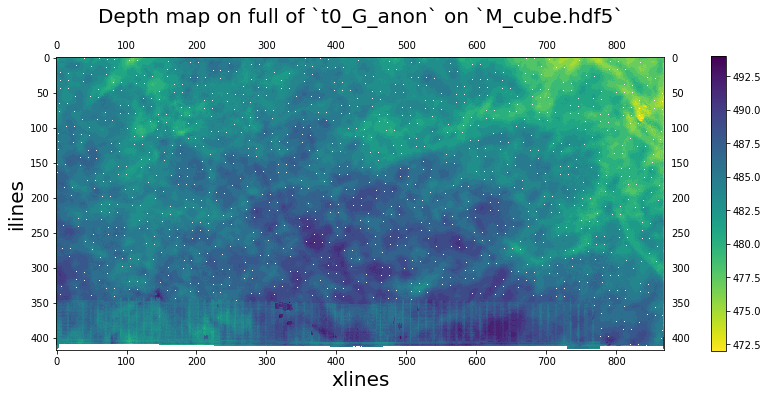

In [17]:
c_enhance.enhanced_t0_G_anon.show()